In [1]:
from facenet.preprocessing import align_images
from facenet.preprocessing import prewhiten

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras import backend as K
import keras

import tensorflow as tf
from keras.callbacks import TensorBoard

import pickle
import numpy as np
import cv2
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


In [4]:
class DTN:
	def __init__(self, facedet_cascade_path, facenet_model_path, source_path, no_faceslist_path, target_path,
								train_batchsize=16, batch_save_frequency=100, verbose=False, from_ckpt=False, predict=False):
		self.verbose = verbose

		self.log_path = "./logs"
		self.save_path = "./model"

		if not os.path.exists(self.log_path):
			os.makedirs(self.log_path)
		if not os.path.exists(self.save_path):
			os.makedirs(self.save_path)

		self.batch_save_frequency = batch_save_frequency

		# Initialize model and optimizer weight paths
		self.from_ckpt = True
		self.weight_paths = ()
		self.ckpt_number = -1

		self.initialize_ckpt_paths(from_ckpt)

		self.img_rows = 160
		self.img_cols = 160
		self.channels = 3
		self.img_shape = (self.img_rows, self.img_cols, self.channels)

		self.train_batchsize = train_batchsize
		self.optimizer = Adam(0.0002, 0.5)

		self.discriminator = self.build_discriminator()

		if self.from_ckpt:
			self.discriminator.load_weights(self.weight_paths[0])
			if self.verbose: print("Discriminator model loaded!\n")

		self.discriminator.compile(loss='categorical_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

		if not self.from_ckpt:
			if self.verbose: print("Discriminator built and compiled!\n")

		self.cascade_facedet = cv2.CascadeClassifier(facedet_cascade_path)

		if self.verbose: print("Face detection model Loaded!\n")

		self.encoder_f = load_model(facenet_model_path)
		self.encoder_f.name += '_0'
		self.encoder_f.trainable = False

		if self.verbose: print("Encoder_0 loaded!\n")

		self.encoder_f2 = load_model(facenet_model_path)
		self.encoder_f2.name += '_1'
		self.encoder_f2.trainable = False

		if self.verbose: print("Encoder_1 loaded!\n")

		if self.from_ckpt:
			self.decoder_g = load_model(self.weight_paths[2])
			if self.verbose: print("Generator model loaded!\n")
		else:
			self.decoder_g = self.build_decoder_g()
			if self.verbose: print("Generator built!\n")

		self.discriminator.trainable = False

		# all class members should be initialized in the init function first
		self.dtn = Model()
		self.build_dtn()

		if self.verbose: print("DTN model built!\n")

		# source_path/source_image
		no_faces_list = list(np.load(no_faceslist_path))
		self.source_path = source_path
		self.source_images = [image for image in os.listdir(source_path) if image.endswith(".jpg") and
																			image not in no_faces_list]
		self.n_source_images = len(self.source_images)

		if self.verbose: print("Source dataset processed!\n")

		# target_path/target_dict.key/target_dict.value
		self.target_path = target_path
		self.target_dict = {}
		target_dirs = os.listdir(target_path)
		for target_dir in target_dirs:
			target_dir_path = os.path.join(self.target_path, target_dir)
			if os.path.isdir(target_dir_path):
				self.target_dict[target_dir] = [image for image in os.listdir(target_dir_path) if image.endswith(".png")]

		if self.verbose: print("Target dataset processed!\n")

		if predict and self.from_ckpt:
			self.pred_model = Model()
			self.build_pred_network()

	def initialize_ckpt_paths(self, from_ckpt):
		all_ckpts = list(set([int(model_name[:-3].split("_")[-1]) for model_name in os.listdir(self.save_path)
								if model_name.endswith(".h5")]))

		if type(from_ckpt) == int:  # Provide batch number to be picked up
			if self.verbose: print("Batch number provided\n")
			ckpt_number = from_ckpt
			self.ckpt_number = ckpt_number
			if ckpt_number in all_ckpts:
				self.from_ckpt = True
				d_weights_path = os.path.join(self.save_path, "discriminator_" + str(ckpt_number) + ".h5")
				d_optimizer_path = os.path.join(self.save_path, "discriminator_" + str(ckpt_number) + "_weights.pkl")
				g_model_path = os.path.join(self.save_path, "generator_" + str(ckpt_number) + ".h5")
				dtn_optimizer_path = os.path.join(self.save_path, "dtn_" + str(ckpt_number) + "_weights.pkl")
				self.weight_paths = (d_weights_path, d_optimizer_path, g_model_path, dtn_optimizer_path)
			else:
				self.from_ckpt = False

		elif isinstance(from_ckpt, tuple):  # Provide paths of model and optimizer weights directly
			if self.verbose: print("Weight paths provided\n")
			self.from_ckpt = True
			self.weight_paths = from_ckpt  # (d_weights.h5, d_optimizer.pkl, dtn_weights.h5, dtn_optimizer.pkl)

		elif from_ckpt==True:  # Pick up most recent checkpoint
			if self.verbose: print("Latest weight paths taken\n")
			if all_ckpts:
				self.from_ckpt = True
				ckpt_number = max(all_ckpts)
				self.ckpt_number = ckpt_number
				d_weights_path = os.path.join(self.save_path, "discriminator_" + str(ckpt_number) + ".h5")
				d_optimizer_path = os.path.join(self.save_path, "discriminator_" + str(ckpt_number) + "_weights.pkl")
				g_model_path = os.path.join(self.save_path, "generator_" + str(ckpt_number) + ".h5")
				dtn_optimizer_path = os.path.join(self.save_path, "dtn_" + str(ckpt_number) + "_weights.pkl")
				self.weight_paths = (d_weights_path, d_optimizer_path, g_model_path, dtn_optimizer_path)
			else:
				self.from_ckpt = False

		else:  # Train from scratch
			if self.verbose: print("No weights chosen; training from scratch\n")
			self.from_ckpt = False

		if self.from_ckpt:
			assert len(self.weight_paths) == 4

	def build_discriminator(self):

		init = RandomNormal(stddev=0.02)
		model = Sequential()

		model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init, input_shape=self.img_shape))
		model.add(LeakyReLU(alpha=0.2))

		model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init))
		model.add(LeakyReLU(alpha=0.2))

		model.add(Flatten())
		model.add(Dense(3, activation='softmax'))

		return model

	def encoder_preprocess(self, image):
		aligned_image = align_images(self.cascade_facedet, image)
		return aligned_image

	def build_decoder_g(self):
		init = RandomNormal(stddev=0.02)
		model = Sequential()

		n_nodes = 128 * 40 * 40
		encoded_op_shape = 128
		model.add(Dense(n_nodes, kernel_initializer=init, input_dim=encoded_op_shape))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Reshape((40, 40, 128)))
		# 80x80x128:
		model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init))
		model.add(LeakyReLU(alpha=0.2))
		# 160x160x128:
		model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init))
		model.add(LeakyReLU(alpha=0.2))
		# 160x160x3:
		model.add(Conv2D(3, (7, 7), activation='tanh', padding='same', kernel_initializer=init))

		return model

	@staticmethod
	def L_custom_wrapper(source):
		def L_custom(y_true, y_pred):
			return source*(y_true - y_pred)**2
		return L_custom

	def build_dtn(self):
		alpha = 100
		beta = 1

		source_const = Input(shape=(1,))
		source_tid = Input(shape=(1,1,1))
		inp = Input(shape=self.img_shape)
		encoded_op = self.encoder_f(inp)
		generator_op = self.decoder_g(encoded_op)

		discriminator_op = self.discriminator(generator_op)

		encoded_op2 = self.encoder_f2(generator_op)

		self.dtn = Model(inputs=[inp, source_const, source_tid], outputs=[discriminator_op, encoded_op2, generator_op])

		losses = ['categorical_crossentropy', self.L_custom_wrapper(source_const), self.L_custom_wrapper(source_tid)]
		loss_weights = [1, alpha, beta]

		self.dtn.compile(loss=losses, loss_weights=loss_weights, optimizer=self.optimizer)

		# Figure out how to initiliaze optimizer with weights shape. 
		# This seems to work only after training one batch:
		# if self.from_ckpt==True:
		# 	with open(self.weight_paths[2], 'rb') as f:
		# 		opt_values = pickle.load(f)
		# 	self.dtn.optimizer.set_weights(opt_values)
		# 	self.from_ckpt = False

		print("\n\n" + "*" * 15)
		print("DTN SUMMARY:")
		print(self.dtn.summary())

		# plot_model(self.dtn, to_file='./dtn_plot.png', show_shapes=True, show_layer_names=True)

	@staticmethod
	def trim_around_images(image, margin=20):
		h, w, c = image.shape
		trimmed_image = image[int(h * margin / 100):int(h * (100 - margin) / 100),
									int(w * margin / 100):int(w * (100 - margin) / 100), :]
		return trimmed_image

	def load_target(self, batch_size=None):
		if not batch_size:
			batch_size = self.train_batchsize

		random_key = np.random.choice(list(self.target_dict.keys()))
		subdir_image_paths = [os.path.join(self.target_path, random_key, image_name)
								for image_name in np.random.choice(self.target_dict[random_key], batch_size)]
		batch_images = [cv2.imread(image_path) for image_path in subdir_image_paths]
		trimmed_batch_images = [self.trim_around_images(image) for image in batch_images]
		prewhited_batch_images = [cv2.resize(prewhiten(image), (self.img_rows, self.img_cols), cv2.INTER_NEAREST)
								for image in trimmed_batch_images]

		batch_as_numpy = np.empty((batch_size, self.img_rows, self.img_cols, self.channels))
		for i in range(batch_size):
			batch_as_numpy[i, :, :, :] = prewhited_batch_images[i]
		return batch_as_numpy

	def load_source(self, batch_size=None):
		if not batch_size:
			batch_size = self.train_batchsize
		batch_image_paths = [os.path.join(self.source_path, image_name) for image_name in
												np.random.choice(self.source_images, batch_size)]
		batch_images = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in batch_image_paths]
		batch_images_aligned = [self.encoder_preprocess(image) for image in batch_images]
		batch_as_numpy = np.empty((batch_size, self.img_rows, self.img_cols, self.channels))
		for i in range(batch_size):
			batch_as_numpy[i, :, :, :] = batch_images_aligned[i]
		return batch_as_numpy

	@staticmethod
	def write_log(callback, names, logs, batch_no):
		# ------------------------------------------------------ #
		# ----- Check link for TensorBoard implementation ------ #
		# https://github.com/eriklindernoren/Keras-GAN/issues/52 #
		# ------------------------------------------------------ #

		for name, value in zip(names, logs):
			summary = tf.Summary()
			summary_value = summary.value.add()
			summary_value.simple_value = value
			summary_value.tag = name
			callback.writer.add_summary(summary, batch_no)
			callback.writer.flush()

	def save_model(self, model, model_type, batch_number):
		"""
		:param model: model to be saved
		:param model_type: discriminator/generator
		:param batch_number: batch number (duh!)
		:return: None
		"""
		model_prefix = model_type + "_" + str(batch_number)

		if model_type == 'discriminator':
			model_path = os.path.join(self.save_path, model_prefix + ".h5")
			model.save_weights(model_path)

		if model_type != 'generator':
			symbolic_weights = getattr(model.optimizer, "weights")
			weight_values = K.batch_get_value(symbolic_weights)
			weight_path = os.path.join(self.save_path, model_prefix + "_weights.pkl")
			with open(weight_path, 'wb') as f:
				pickle.dump(weight_values, f)
		else:
			model_path = os.path.join(self.save_path, model_prefix + ".h5")
			model.save(model_path)

	def train(self, epochs):
		if self.verbose: print("Training Started!\n")
		batch_size = self.train_batchsize
		y_1 = np.zeros((batch_size, 3))
		y_1[:, 2] = np.ones(batch_size)	 # [0,0,1] for G(x_s)
		y_2 = np.zeros((batch_size, 3))
		y_2[:, 1] = np.ones(batch_size)	 # [0,1,0] for G(x_t)
		y_3 = np.zeros((batch_size, 3))
		y_3[:, 0] = np.ones(batch_size)	 # [1,0,0] for x_t

		y_gang = np.concatenate((y_3, y_3))

		# --------------------------------------------------------------------- #
		# # Alternate method using keras callback --> callback.on_epoch_end() # #
		# # https://gist.github.com/erenon/91f526302cd8e9d21b73f24c0f9c4bb8   # #
		# --------------------------------------------------------------------- #
		# d_callback = keras.callbacks.TensorBoard(log_dir=self.log_path, histogram_freq=0, batch_size=batch_size,
		# 											write_graph=True, write_grads=True)
		# d_callback.set_model(self.discriminator)
		# g_callback = keras.callbacks.TensorBoard(log_dir=self.log_path, histogram_freq=0, batch_size=batch_size,
		# 											write_graph=True, write_grads=True)
		# g_callback.set_model(self.dtn)
		# --------------------------------------------------------------------- #

		d_callback = TensorBoard(self.log_path)
		d_callback.set_model(self.discriminator)
		g_callback = TensorBoard(self.log_path)
		g_callback.set_model(self.dtn)

		if self.ckpt_number != -1 and self.from_ckpt:
			batch_number = self.ckpt_number
			epochs_from_batch_number = np.round(batch_number * batch_size / self.n_source_images, 3)
		else:
			batch_number = 0
			epochs_from_batch_number = 0

		while epochs_from_batch_number <= epochs:
			batch_number = batch_number + 1
			epochs_from_batch_number = np.round(batch_number * batch_size / self.n_source_images, 3)
			x_T = self.load_target(batch_size)
			x_S = self.load_source(batch_size)

			# Important!! :
			# Normalize bitmoji_imgs: update later
			# Normalize faces: update later

			f_x_S = self.encoder_f.predict(x_S)
			f_x_T = self.encoder_f.predict(x_T)

			g_x_S = self.decoder_g.predict(f_x_S)
			g_x_T = self.decoder_g.predict(f_x_T)

			L_D1, acc_D1 = self.discriminator.train_on_batch(g_x_S, y_1)
			L_D2, acc_D2 = self.discriminator.train_on_batch(g_x_T, y_2)
			L_D3, acc_D3 = self.discriminator.train_on_batch(x_T, y_3)

			L_D = L_D1 + L_D2 + L_D3
			acc_D = (acc_D1 + acc_D2 + acc_D3)/3

			if batch_number % self.batch_save_frequency == 0:
				self.save_model(self.discriminator, "discriminator", batch_number)

			self.write_log(d_callback, ['D1_LOSS', 'D2_LOSS', 'D3_LOSS', 'D_LOSS', 'D1_ACC', 'D2_ACC', 'D3_ACC', 'D_ACC'],
								[L_D1, L_D2, L_D3, L_D, acc_D1, acc_D2, acc_D3, acc_D], batch_number)

			x_dtn = np.concatenate((x_S, x_T))

			source_const = np.concatenate((np.ones(batch_size), np.zeros(batch_size)))
			source_tid = np.concatenate((np.zeros((batch_size, 1, 1, 1)), np.ones((batch_size, 1, 1, 1))))

			y_const = np.concatenate((f_x_S, np.zeros_like(f_x_S)))

			y_tid = np.concatenate((np.zeros_like(x_T), x_T))

			L_dtn = self.dtn.train_on_batch([x_dtn, source_const, source_tid], [y_gang, y_const, y_tid])

			# set optimizer state after training one batch:
			if self.from_ckpt and batch_number == 1:
				with open(self.weight_paths[3], 'rb') as f:
					opt_values = pickle.load(f)
				self.dtn.optimizer.set_weights(opt_values)

				with open(self.weight_paths[1], 'rb') as f:
					opt_values = pickle.load(f)
				self.discriminator.optimizer.set_weights(opt_values)

			if batch_number % self.batch_save_frequency == 0:
				self.save_model(self.decoder_g, "generator", batch_number)
				self.save_model(self.dtn, "dtn", batch_number)

			self.write_log(g_callback, ['G_LOSS', 'L_GANG', 'L_CONST', 'L_TID'],
							[L_dtn[0], L_dtn[1], L_dtn[2], L_dtn[3]], batch_number)

			print("batch number: " + str(batch_number) + ", calculated epoch: " + str(epochs_from_batch_number)
								+ ", L_D: " + str(L_D) + ", L_dtn: " + str(L_dtn) + ", accuracy:" + str(acc_D))

		if self.verbose: print("Training completed!\n")

	def build_pred_network(self):
		inp = Input(shape=self.img_shape)
		encoded_op = self.encoder_f(inp)
		generator_op = self.decoder_g(encoded_op)
		self.pred_model = Model(inputs=inp, outputs=generator_op)


In [5]:
facedet_cascade_path = '../keras-facenet/model/cv2/haarcascade_frontalface_alt2.xml'
facenet_model_path = '../keras-facenet/model/new_facenet_keras.h5'
source_path = '/Volumes/Macintosh HD/DTN/img_align_celeba_samples'
target_path = '/Volumes/Macintosh HD/DTN/cartoonset10k_samples'
no_faceslist_path = "./no_faces.npy"

In [6]:
verbose = True
dtn = DTN(facedet_cascade_path, facenet_model_path, source_path, no_faceslist_path, target_path, verbose=verbose, batch_save_frequency=10, from_ckpt=True, train_batchsize=16, predict=True)

Latest weight paths taken

Instructions for updating:
Colocations handled automatically by placer.
Discriminator model loaded!

Face detection model Loaded!



/Users/deepakprabakar/anaconda3/envs/work/lib/python3.5/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Encoder_0 loaded!

Encoder_1 loaded!

Generator model loaded!



***************
DTN SUMMARY:
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
inception_resnet_v1_0 (Model)   (None, 128)          22808144    input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 160, 160, 3)  26962563    inception_resnet_v1_0[1][0]      
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 3)            375939      sequential_2[1][0]              

In [7]:
dtn.pred_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
inception_resnet_v1_0 (Model (None, 128)               22808144  
_________________________________________________________________
sequential_2 (Sequential)    (None, 160, 160, 3)       26962563  
Total params: 49,770,707
Trainable params: 26,962,563
Non-trainable params: 22,808,144
_________________________________________________________________


In [8]:
sample_image = cv2.cvtColor(cv2.imread("/Volumes/Macintosh HD/DTN/img_align_celeba_samples/000085.jpg"), cv2.COLOR_BGR2RGB)
aligned_image = dtn.encoder_preprocess(sample_image)

/Users/deepakprabakar/anaconda3/envs/work/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


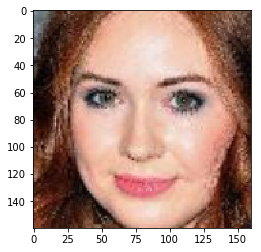

In [9]:
plt.imshow(aligned_image)
batch_as_numpy = np.empty((1, dtn.img_rows, dtn.img_cols, dtn.channels))
batch_as_numpy[0, :, :, :] = aligned_image

In [10]:
op = dtn.pred_model.predict_on_batch(batch_as_numpy)

In [16]:
plt.imshow(op[0])

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
